In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import xarray as xr
import sys,os,glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(0,'../../../')

from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

# Eviromental Dependence of Loading Factors: 3D PDF

See :ref:`quickstart` for details of this step. For this tutorial, we use the default ranges for axes setup.

In [3]:
import twind

tw=twind.TigressWindModel(z0='H',verbose=False)
tw.set_axes(verbose=True)

cs: min=0, max=4, N=500
vout: min=0, max=4, N=500
sfr: min=-6, max=2, N=100


Now we build joint PDFs as a function of SFR surface density, which gives a 3D PDF model.

In [4]:
pdf=tw.build_model(renormalize=True,energy_bias=True,verbose=False)

## Slicing back to 2D PDF

`xarray.Dataset` provides very useful functionality for slicing and interpolating through a method `sel`. Since we build a 3D PDF on the decretized `sfr` array, to get a PDF with a particular choice of `sfr` using the current 3D PDF, we would want either get the PDF with the closet value of `sfr` or interpolate to the chosen `sfr`. This can be done very easily with `xarray`.

In [5]:
# find the nearest one
pdf_nearest=pdf.sel(logsfr=-2, method='nearest')

# intepolate; this takes longer
pdf_interp=pdf.interp(logsfr=-2)

print('log sfr:{} {}'.format(pdf_nearest.logsfr.data,pdf_interp.logsfr.data))

log sfr:-2.04040404040404 -2


Interpolation (or slicing) within the range of `sfr` would be useful to compare pdfs at different SFRs quickly.

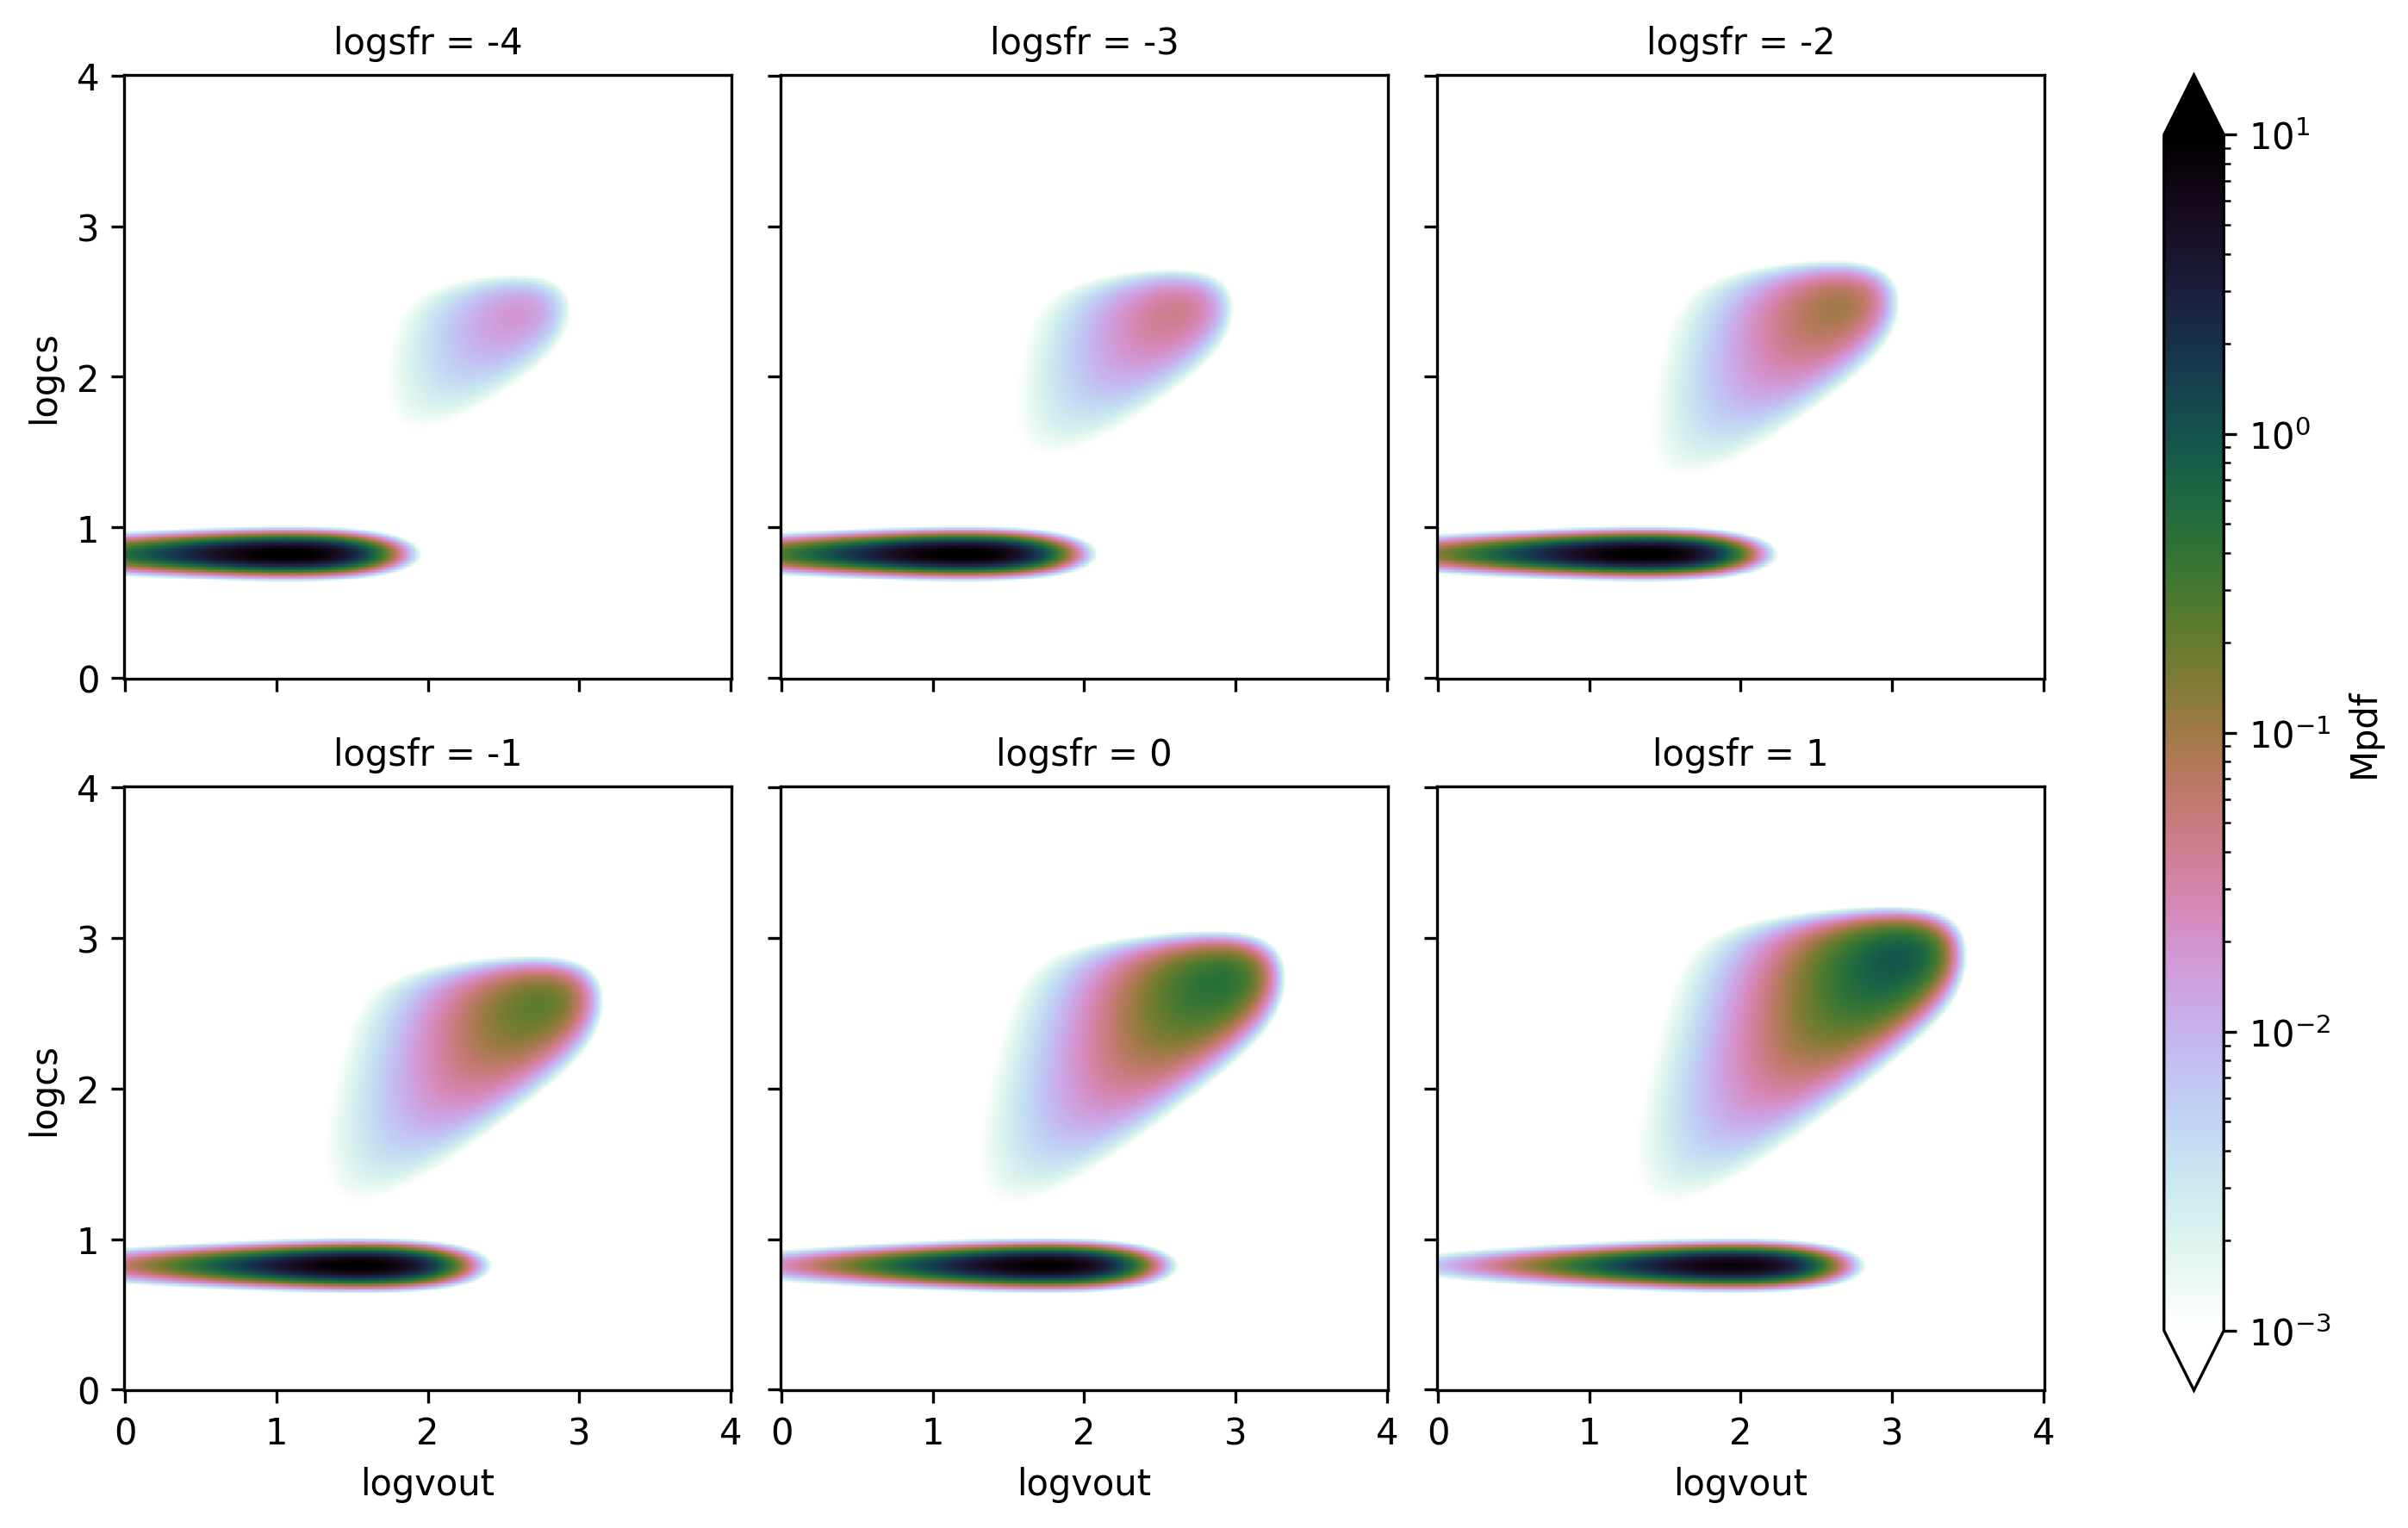

In [6]:
g=pdf['Mpdf'].interp(logsfr=[-4,-3,-2,-1,0,1]).plot(col='logsfr',col_wrap=3,
                                                    norm=LogNorm(vmin=1.e-3,vmax=10),
                                                    cmap=plt.cm.cubehelix_r
                                                   )

## Selecting escapable outflows: constant velocity cut

For a practical use, we may want to select outflows with a certain velocity (or Bernoulli velocity) cut given a halo escape velocity. Here's how to do this. 

We may first want to calculate the cumulative distribution functions (CDF) with `vBz > vBzcut`. We then obtain the loading factors of selected gas by multiplying the total loading factors, which are stored as `etaM`, `etap`, `etaE`, `etaZ` in the original `Dataset`.

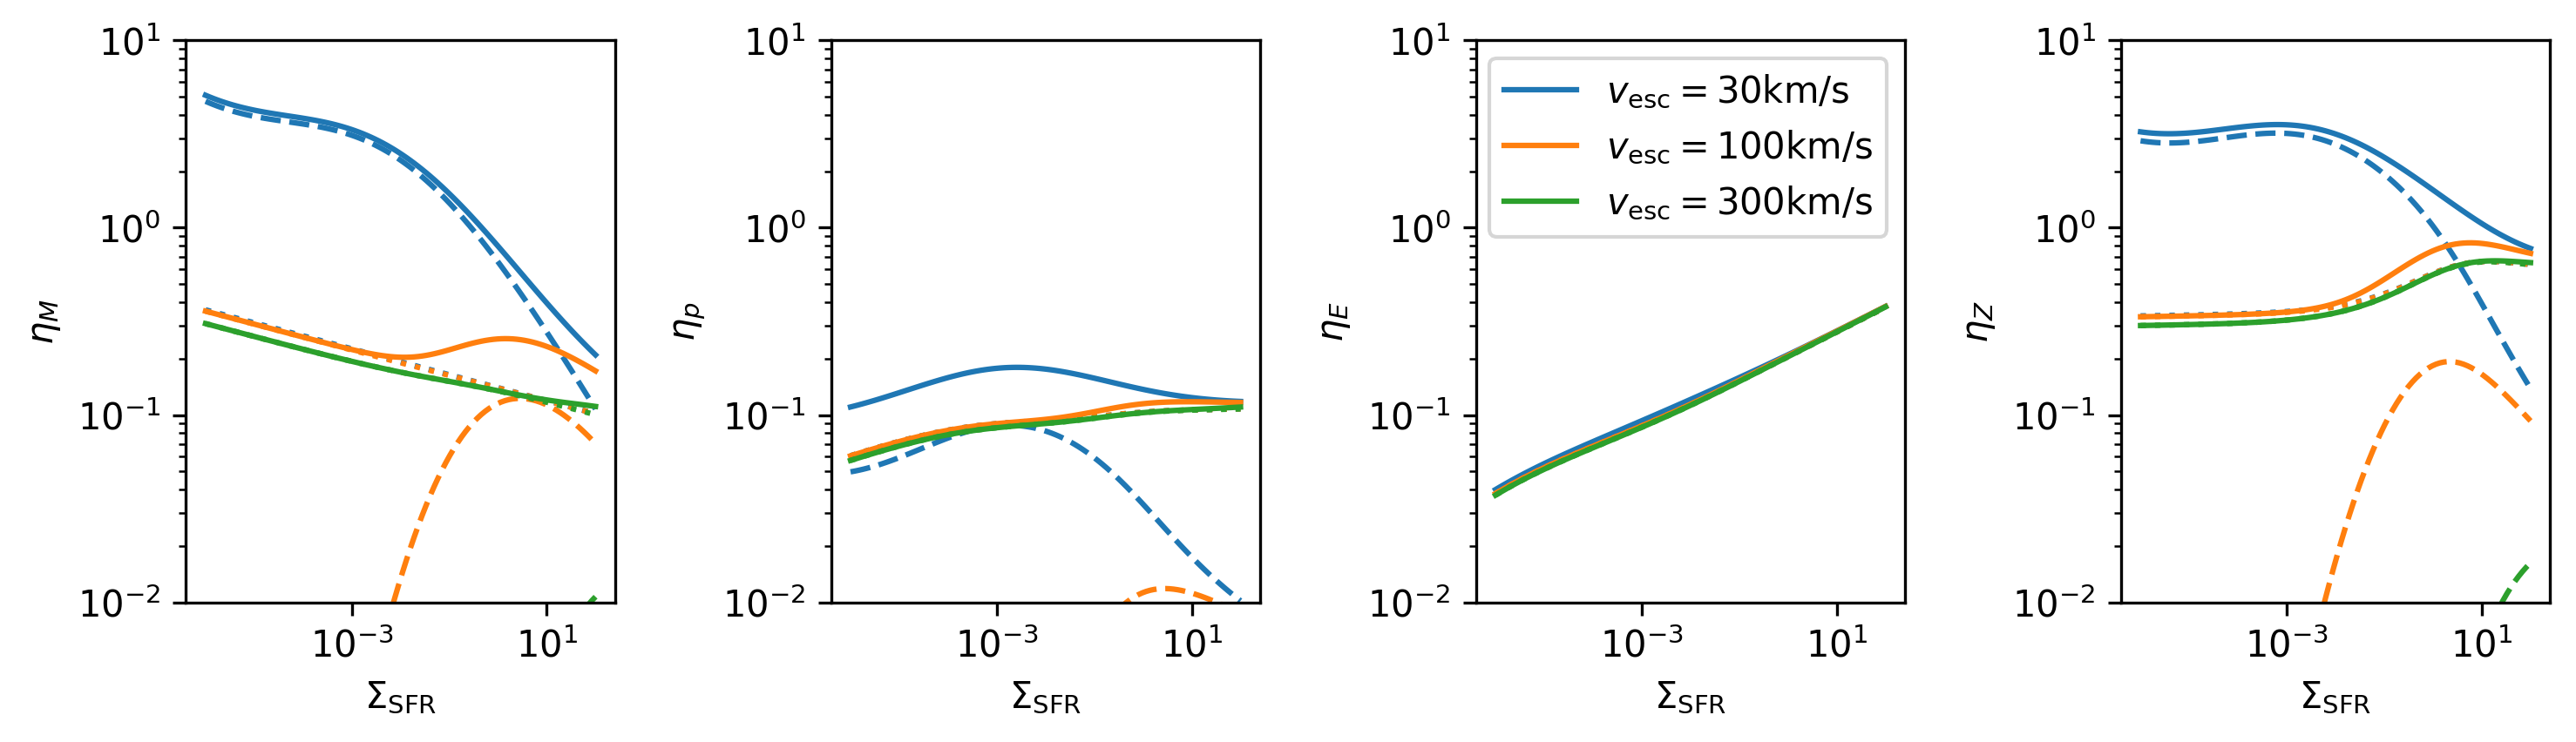

In [7]:
dbinsq=pdf.attrs['dlogcs']*pdf.attrs['dlogvout']
pdfs=['Mpdf','Mpdf-cool','Mpdf-hot',
      'ppdf','ppdf-cool','ppdf-hot',
      'Epdf','Epdf-cool','Epdf-hot',
      'Zpdf','Zpdf-cool','Zpdf-hot',]
sfr=10.**pdf['logsfr']

# For a constant velocity cut
fig, axes = plt.subplots(1,4,figsize=(10,3))
for vBzcut0 in [30,100,300]:
    cdf=pdf[pdfs].where(pdf['vBz']>vBzcut0).sum(dim=['logcs','logvout'])*dbinsq
    for ax,q in zip(axes.flat,['M','p','E','Z']):
        plt.sca(ax)
        eta=pdf['eta'+q]
        l,=plt.plot(sfr,cdf[q+'pdf']*eta,label=r'$v_{{\rm esc}}={}{{\rm km/s}}$'.format(vBzcut0))
        plt.plot(sfr,cdf[q+'pdf-cool']*eta,ls='--',color=l.get_color())
        plt.plot(sfr,cdf[q+'pdf-hot']*eta,ls=':',color=l.get_color())
        plt.ylabel(r'$\eta_{}$'.format(q))
        plt.xlabel(r'$\Sigma_{\rm SFR}$')
axes[2].legend()
plt.setp(axes,'xscale','log')
plt.setp(axes,'yscale','log')
plt.setp(axes,'ylim',(1.e-2,1.e1))
plt.tight_layout()

The mass (and metal) loading factor $\eta_M$ changes dramatically as different velocity cuts are applied. This is because the cool outflow carries most of mass (shown as dashed lines), which has typical outflow velocities insufficient to escape for $v_{\rm esc}>100 {\rm km/s}$. However, at very high $\Sigma_{\rm SFR}$, cold outflow may contribute to the mass outflow rate significantly again, while one should take this with a grain of salt since those are outside our original parameter space $10^{-4}<\Sigma_{\rm SFR}<1$ over which the model is calibrated. On the other hand, the energy loading factor $\eta_E$ is unchaged since it is dominated by the hot outflow whose Bernoulli velocity is already larger than 300km/s even at low $\Sigma_{\rm SFR}$.

## Selecting escapable outflows: SFR-dependent velocity cut

For some reasons, if the escape velocity is a function of SFR surface density, we get loading factors with a varying `vBzcut` easily using `xarray.Dataset.where` as it correctly broadcasts the information. Let's assume a particular form of the escape velocity:

$$ v_{\rm esc} = 300{\rm km/s}\frac{\Sigma_{\rm SFR}^{1/2}}{\Sigma_{\rm SFR}^{1/2}+1}+30{\rm km/s} $$

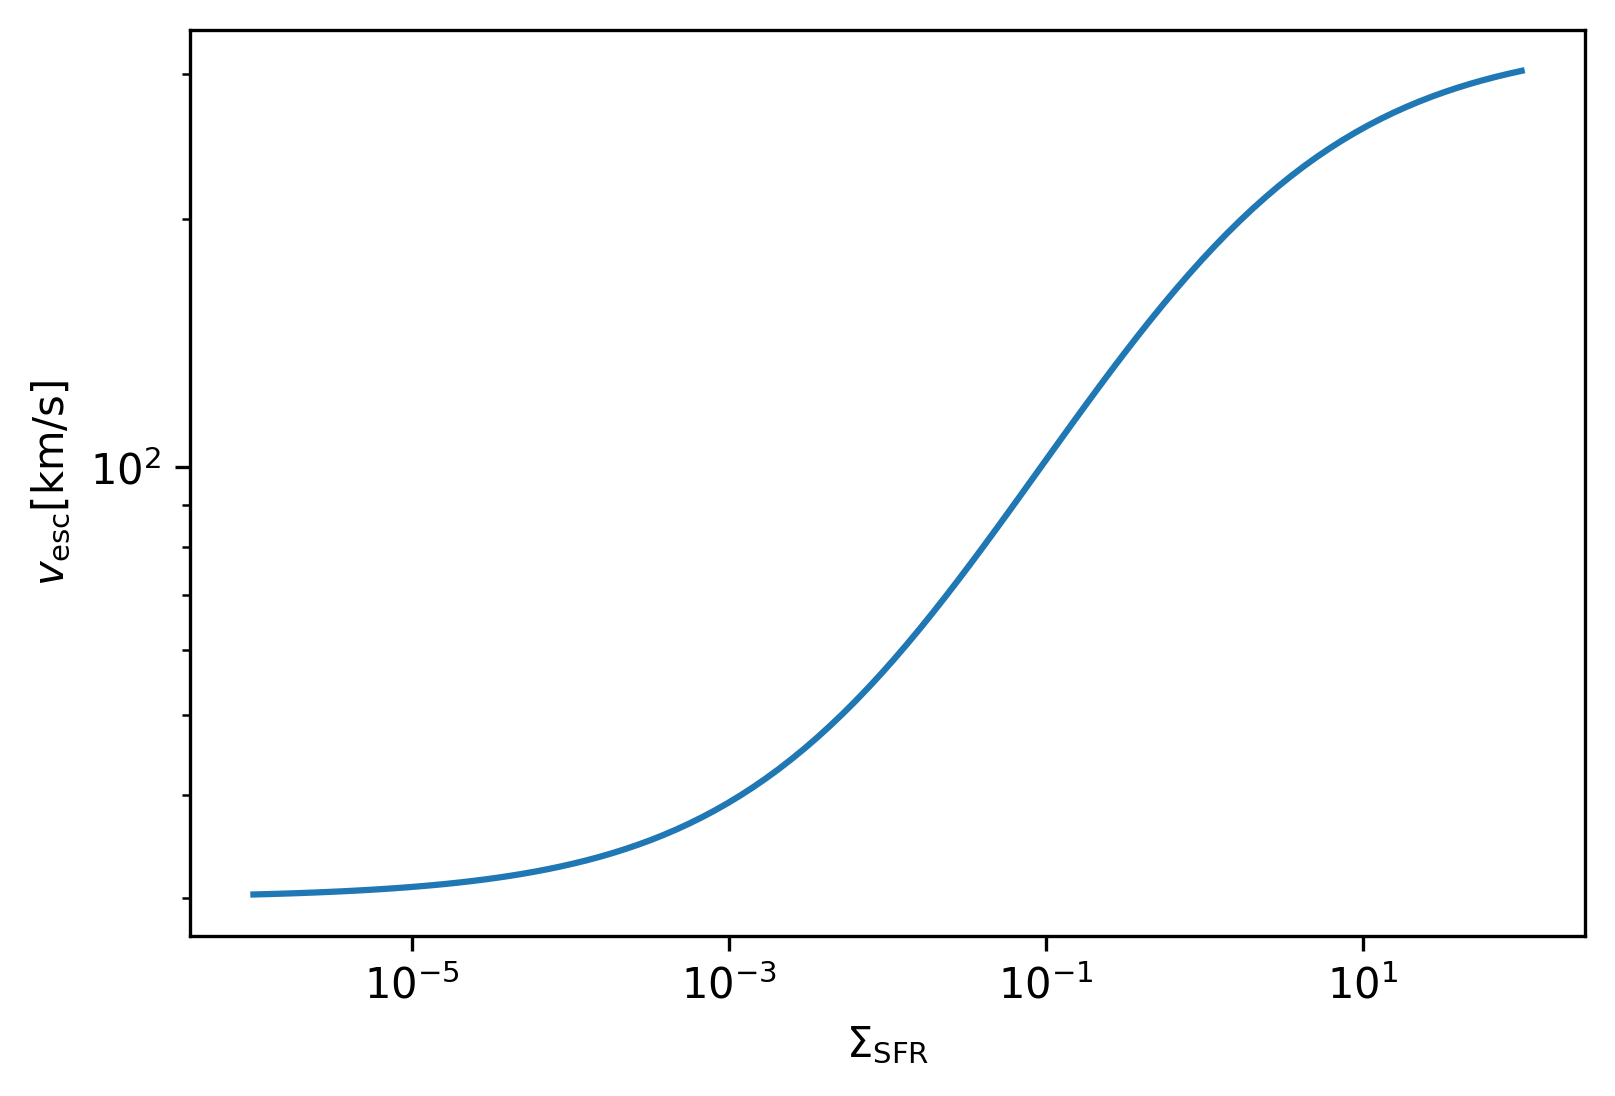

In [8]:
vBzcut = 300.*sfr**0.5/(sfr**0.5+1)+30
plt.loglog(sfr,vBzcut)
plt.xlabel(r'$\Sigma_{\rm SFR}$');
plt.ylabel(r'$v_{\rm esc} [{\rm km/s}]$');

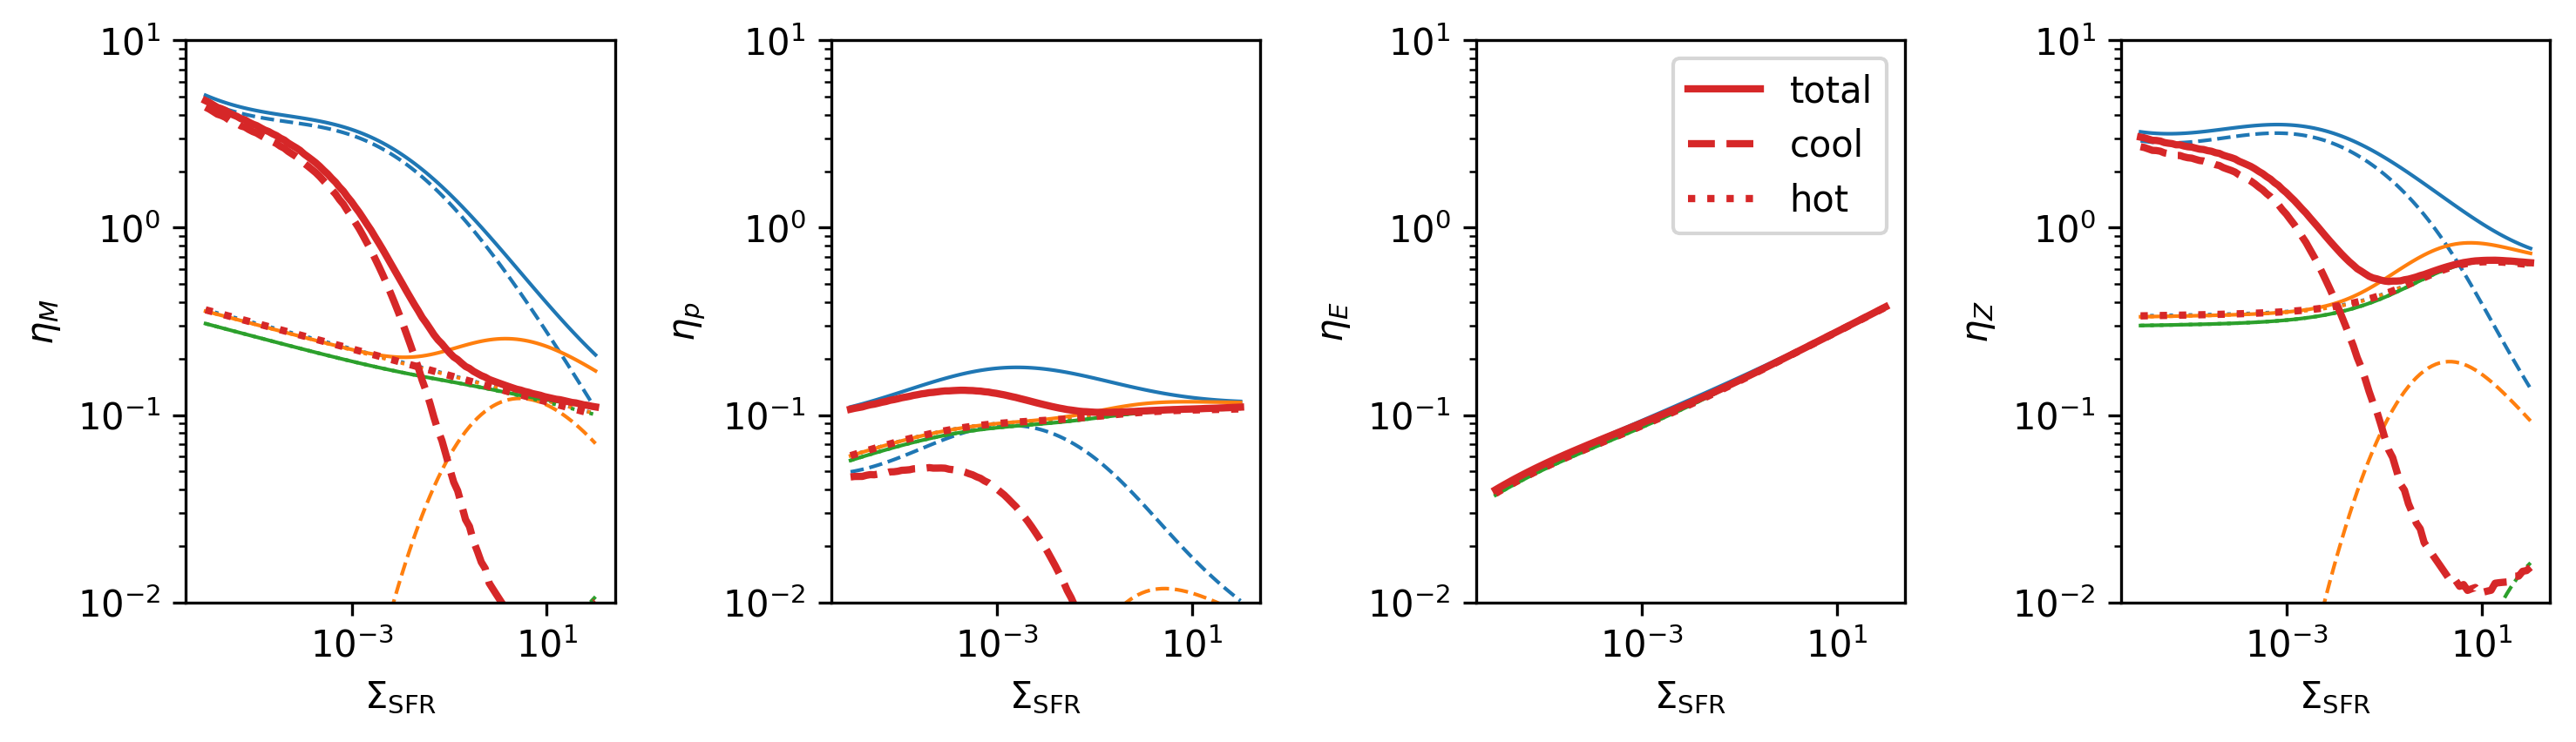

In [9]:
fig, axes = plt.subplots(1,4,figsize=(10,3))

for vBzcut0 in [30,100,300]:
    cdf=pdf[pdfs].where(pdf['vBz']>vBzcut0).sum(dim=['logcs','logvout'])*dbinsq
    for ax,q in zip(axes.flat,['M','p','E','Z']):
        plt.sca(ax)
        eta=pdf['eta'+q]
        l,=plt.plot(sfr,cdf[q+'pdf']*eta,lw=1)
        plt.plot(sfr,cdf[q+'pdf-cool']*eta,ls='--',color=l.get_color(),lw=1)
        plt.plot(sfr,cdf[q+'pdf-hot']*eta,ls=':',color=l.get_color(),lw=1)
        plt.ylabel(r'$\eta_{}$'.format(q))
        plt.xlabel(r'$\Sigma_{\rm SFR}$')

cdf=pdf[pdfs].where(pdf['vBz']>vBzcut).sum(dim=['logcs','logvout'])*dbinsq
for ax,q in zip(axes.flat,['M','p','E','Z']):
    plt.sca(ax)
    eta=pdf['eta'+q]
    l,=plt.plot(sfr,cdf[q+'pdf']*eta,label='total',lw=2)
    plt.plot(sfr,cdf[q+'pdf-cool']*eta,ls='--',color=l.get_color(),label='cool',lw=2)
    plt.plot(sfr,cdf[q+'pdf-hot']*eta,ls=':',color=l.get_color(),label='hot',lw=2)
    plt.ylabel(r'$\eta_{}$'.format(q))
    plt.xlabel(r'$\Sigma_{\rm SFR}$')
axes[2].legend()

plt.setp(axes,'xscale','log')
plt.setp(axes,'yscale','log')
plt.setp(axes,'ylim',(1.e-2,1.e1))
plt.tight_layout()

Obviously, the result (red) falls between `vBzcut0=30` (blue) and `vBzcut0=300` (green) cases.